## Predict 2 meter temperature with sea surface temperature using LSTM
This notebook serves as an example of a basic workflow of data driven forecasting using deep learning with `s2spy` & `lilio` packages. <br>
We will predict temperature in US at seasonal time scales using ERA5 dataset with LSTM network. <br>

<img src="../assets/concept_test_case.png" alt="usecase" width="500"/>

This recipe includes the following steps:
- Define a calendar (`lilio`)
- Download/load input data (`era5cli`) (test data, accessible via `era5cli`)
- Map the calendar to the data (`lilio`)
- Train-validate-test split (60%/20%/20%)
- Preprocessing based on the training set (`s2spy`)
- Resample data to the calendar (`lilio`)
- Create LSTM model (`torch`)
- Specify hyper-parameters (`wandb`)
- Train model (`torch`)
- Evaludate model

The workflow is illustrated below:

<img src="../assets/dl.PNG" alt="Transformer" width="900"/>

In [84]:
import lilio
import numpy as np
import pandas as pd
import time as tt
import wandb
import sys
import urllib
import xarray as xr
from pathlib import Path
from s2spy import preprocess
import torch
from torch import nn
from torch.autograd import Variable
from sklearn.metrics import mean_squared_error

# import utils function to check the statistics of parameters
sys.path.append("../src/")
import utils
# for reproducibility 
np.random.seed(1)
torch.manual_seed(2)


#### Define a calendar with `lilio` to specify time range for targets and precursors.

In [85]:
# create custom calendar based on the time of interest
calendar = lilio.Calendar(anchor="07-01", allow_overlap=True)
# add target periods
calendar.add_intervals("target", length="30d", gap="1M")
# add precursor periods
periods_of_interest = 8
calendar.add_intervals("precursor", "1M", n=periods_of_interest)

In [86]:
# check calendar
calendar

Calendar(
    anchor='07-01',
    allow_overlap=True,
    mapping=None,
    intervals=[
        Interval(role='target', length='30d', gap='1M'),
        Interval(role='precursor', length='1M', gap='0d'),
        Interval(role='precursor', length='1M', gap='0d'),
        Interval(role='precursor', length='1M', gap='0d'),
        Interval(role='precursor', length='1M', gap='0d'),
        Interval(role='precursor', length='1M', gap='0d'),
        Interval(role='precursor', length='1M', gap='0d'),
        Interval(role='precursor', length='1M', gap='0d'),
        Interval(role='precursor', length='1M', gap='0d')
    ]
)

#### Load test data SST and (clustered) T2M
For the sake of batch size, we use 61 years (1961-2021) of data.

In [87]:
# URL of the dataset from zenodo
sst_url = "https://zenodo.org/record/8186914/files/sst_daily_1959-2021_5deg_Pacific_175_240E_25_50N.nc"
t2m_url = "https://zenodo.org/record/8186914/files/t2m_daily_1959-2021_2deg_clustered_226_300E_30_70N.nc"
sst_field = "sst_daily_1959-2021_5deg_Pacific_175_240E_25_50N.nc"
t2m_field = "t2m_daily_1959-2021_2deg_clustered_226_300E_30_70N.nc"

urllib.request.urlretrieve(sst_url, sst_field)
urllib.request.urlretrieve(t2m_url, t2m_field)

('t2m_daily_1959-2021_2deg_clustered_226_300E_30_70N.nc',
 <http.client.HTTPMessage at 0x2afd59060>)

In [88]:
# load data
precursor_field = xr.open_dataset(sst_field)
precursor_field = precursor_field.sel(time=slice("19610101","20211231"))
target_field = xr.open_dataset(t2m_field)
target_field = target_field.sel(time=slice("19610101","20211231"))

In [89]:
# Convert Klevin to Celcius
precursor_field["sst"] = precursor_field["sst"] - 273.15
target_field["t2m"] = target_field["t2m"] - 273.15

#### Map the calendar to the data
After mapping the calendar to the field, we can visualize our calendar by calling the `visualize` method.

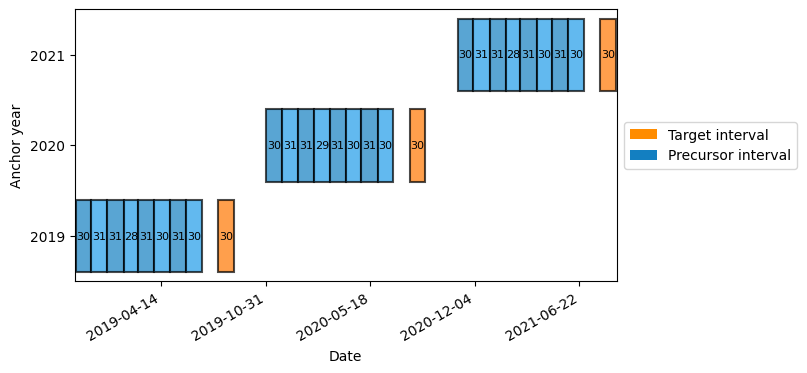

In [90]:
# map calendar to data
calendar.map_to_data(precursor_field)
calendar.visualize(show_length=True)

Also, we can get a list of all intervals by running the following line. There, you will find the intervals `-1` and `1`, which corresponds to the creation of a precursor interval (negative integer(s)) and a target interval (positive integer(s)), respectively. <br>

For more information about the definition of intervals, and how `lilio` works, please check the [README](https://github.com/AI4S2S/lilio) of `lilio`.

In [91]:
calendar.show()[:3]

i_interval,-8,-7,-6,-5,-4,-3,-2,-1,1
anchor_year,,,,,,,,,
2021,"[2020-11-01, 2020-12-01)","[2020-12-01, 2021-01-01)","[2021-01-01, 2021-02-01)","[2021-02-01, 2021-03-01)","[2021-03-01, 2021-04-01)","[2021-04-01, 2021-05-01)","[2021-05-01, 2021-06-01)","[2021-06-01, 2021-07-01)","[2021-08-01, 2021-08-31)"
2020,"[2019-11-01, 2019-12-01)","[2019-12-01, 2020-01-01)","[2020-01-01, 2020-02-01)","[2020-02-01, 2020-03-01)","[2020-03-01, 2020-04-01)","[2020-04-01, 2020-05-01)","[2020-05-01, 2020-06-01)","[2020-06-01, 2020-07-01)","[2020-08-01, 2020-08-31)"
2019,"[2018-11-01, 2018-12-01)","[2018-12-01, 2019-01-01)","[2019-01-01, 2019-02-01)","[2019-02-01, 2019-03-01)","[2019-03-01, 2019-04-01)","[2019-04-01, 2019-05-01)","[2019-05-01, 2019-06-01)","[2019-06-01, 2019-07-01)","[2019-08-01, 2019-08-31)"


#### Train-validate-test split based on the anchor years (60%/20%/20% split)

In [92]:
# get 60% of instance as training
years = sorted(calendar.get_intervals().index)
train_samples = round(len(years) * 0.6)
test_samples = round(len(years) * 0.2)
start_year = years[0]

#### Fit preprocessor with training samples and preprocess data
In this step, we remove trend and take anomalies for the precursor field. Note that here we use raw daily data for detrending and taking anomalies. <br>

In general, there are many "flavors" of preprocessing, like when to perform this operation, and in which order do we want to preprocess the data. To improve the transparency and reproducibility of our work, we think it is necessary to standardize these steps. To stick to the best practices, we suggest to preprocess your data in the following way.

In [93]:
# create preprocessor
preprocessor = preprocess.Preprocessor(
    rolling_window_size=25,
    detrend="linear",
    subtract_climatology=True,
)

# fit preprocessor with training data
preprocessor.fit(
    precursor_field.sel(
        time=slice(str(start_year), str(start_year + train_samples - 1))
    )
)

In [94]:
# preprocess the whole precursor field
precursor_field_prep = preprocessor.transform(precursor_field)

#### Resample data to the calendar

In [95]:
precursor_field_resample = lilio.resample(calendar, precursor_field_prep)
target_field_resample = lilio.resample(calendar, target_field)

In [96]:
# select variables and intervals
precursor_field_sel = precursor_field_resample['sst']
# selecting 1-d timeseries of cluster 3 for target
target_series_sel = target_field_resample['t2m'].sel(cluster=3) 

We need to convert our data to `torch.Tensor`.

In [97]:
# slice and reshape input desired by LSTM (samples, lags, space)
sequence_lags_precursor = len(precursor_field_sel.i_interval) - 1 # we only take precursor parts of i intervals
lat_precursor = len(precursor_field_sel.latitude)
lon_precursor = len(precursor_field_sel.longitude)

X_torch = torch.from_numpy(precursor_field_sel[:,:-1,:,:].data).type(torch.FloatTensor)
y_torch = torch.from_numpy(target_series_sel[:,-1].data).type(torch.FloatTensor)

# shape (samples, lags, space)
X_torch = X_torch.view(-1, sequence_lags_precursor, lat_precursor*lon_precursor)

# turn nan to 0.0
X_torch = torch.nan_to_num(X_torch, 0.0)

We split our data into train/cross-validate/test sets.

In [98]:
# train/validate/test split and use pytorch dataloader
train_X_torch = X_torch[:train_samples]
train_y_torch = y_torch[:train_samples]

valid_X_torch = X_torch[train_samples:train_samples + test_samples]
valid_y_torch = y_torch[train_samples:train_samples + test_samples]

test_X_torch = X_torch[-test_samples:]
test_y_torch = y_torch[-test_samples:]

# pytorch train and test sets
train_set = torch.utils.data.TensorDataset(train_X_torch, train_y_torch)
valid_set = torch.utils.data.TensorDataset(valid_X_torch, valid_y_torch)
test_set = torch.utils.data.TensorDataset(test_X_torch, test_y_torch)

#### Build LSTM model
Build a LSTM model with `nn.LSTM` module.

The architecture of the autoencoder used here is shown in the figure below.

<img src="../assets/lstm.png" alt="LSTM" width="500"/>

(source of image: https://colah.github.io/posts/2015-08-Understanding-LSTMs/)

In [99]:
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim=1,
                 batch_size=1, num_layers=1, dropout=0.1):
        """
        Initialize the LSTM model in Pytorch and specify the basic model structure.
        Expected input timeseries dimension [batch_size, sequence, channels]

        args:
            input_dim: The number of expected features in the input x
            hidden_dim: The number of features in the hidden state h
            output_dim: The number of output features h
            num_layers: Number of recurrent layers. E.g., setting num_layers=2 would 
              mean stacking two LSTMs together to form a stacked LSTM, with the second 
              LSTM taking in outputs of the first LSTM and computing the final results. 
              Default: 1
        """
        super().__init__()
        self.hidden_dim = hidden_dim
        self.batch_size = batch_size 
        self.num_layers = num_layers
        # Define the LSTM layer
        self.lstm = nn.LSTM(input_size = input_dim, hidden_size = hidden_dim,
                            num_layers = num_layers, batch_first = True, dropout = dropout)

        # Define the output layer
        self.linear = nn.Linear(hidden_dim, output_dim)
        
    def init_hidden(self):
        """Initialize hidden state with random values."""
        return (torch.randn(self.num_layers, self.batch_size, self.hidden_dim),
                torch.randn(self.num_layers, self.batch_size, self.hidden_dim))
        
    def forward(self, input):
        (h_0, c_0) = self.init_hidden()
        x, _ = self.lstm(input, (h_0, c_0))
        x = self.linear(x)
            
        return x

Print system info.

In [100]:
print ("Pytorch version {}".format(torch.__version__))
use_cuda = torch.cuda.is_available()
print("Is CUDA available? {}".format(use_cuda))
# use GPU if possible
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device to be used for computation: {}".format(device))

Pytorch version 2.0.1
Is CUDA available? False
Device to be used for computation: cpu


#### Hyper-parameter tuning with W&B
We use Weight&Biases to monitor the training process. It is very simple to integrate it into our workflow and more information about how to set it up can be found at https://docs.wandb.ai/quickstart. <br>

You'll need an account, a team, and a project if you'll want to track runs online. Otherwise, you can simply run the code by setting mode = 'disabled' (W&B will not be active). 

In [101]:
# define hyperparameters and the 
hyperparameters = dict(
    epoch = 150,
    input_dim = lat_precursor*lon_precursor,
    hidden_dim = lat_precursor*lon_precursor*2,
    output_dim = 1,
    batch_size = 6, 
    num_layers = 2,
    dropout = 0.0,
    learning_rate = 0.02,
    dataset = 'Weather',
    architecture = 'LSTM'
)

# call weights & biases service
wandb.login()

# initialize weights & biases service
mode = 'disabled'
mode = 'online' # <- uncomment this line to enable wandb
team = 'ai4s2s-demo' # <- your own team namehere
project = 'test-LSTM' # <- your own project name here
wandb.init(config=hyperparameters, project=project, entity=team, mode=mode)
config = wandb.config

Create data loaders with chosen batch size. 

In [102]:
# create data loader and use batch 
train_loader = torch.utils.data.DataLoader(train_set, batch_size = config.batch_size, shuffle = True)
valid_loader = torch.utils.data.DataLoader(valid_set, batch_size = config.batch_size, shuffle = True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size = config.batch_size, shuffle = True)

#### Initialize and train model
Create model using specified hyperparameter. Initialize model and choose loss function and optimizer.

In [103]:
# Initialize model
model = LSTM(input_dim = config["input_dim"],
             hidden_dim = config["hidden_dim"],
             output_dim = config["output_dim"], 
             batch_size = config["batch_size"], 
             num_layers = config["num_layers"]
)
# Specify loss function
criterion = nn.MSELoss()
# Choose optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=config.learning_rate)
# Print model and optimizer details
print('Model details:\n', model)
print('Optimizer details:\n',optimizer)
wandb.watch(model)

Model details:
 LSTM(
  (lstm): LSTM(65, 130, num_layers=2, batch_first=True, dropout=0.1)
  (linear): Linear(in_features=130, out_features=1, bias=True)
)
Optimizer details:
 Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.02
    maximize: False
    weight_decay: 0
)


[]

In [104]:
# display the total number of parameters
utils.total_num_param(model)
# for more details about the trainable parameter in each layer
#utils.param_trainable(model)

238811


Start the training and cross validation loop.

In [105]:
# calculate the time for the code execution
start_time = tt.time()

# switch model into training mode
model.train()

hist_train = []
hist_valid = []
for epoch in range(config.epoch):
    # training loop
    # switch model into train mode
    model.train()
    hist_train_step = 0
    for batch_idx, (X_batch, y_batch) in enumerate(train_loader):
        var_X_batch = Variable(X_batch).to(device)
        var_y_batch = Variable(y_batch).to(device)
        optimizer.zero_grad()
        # note: decoder input is the last instance of encoder input
        output = model(var_X_batch)
        loss = criterion(output[:,-1,:].squeeze(), var_y_batch) # we only need the last instance from output sequence
        loss.backward()
        optimizer.step()
        wandb.log({'train_loss': loss.item()})
        print(f'Epoch : {epoch} [{batch_idx*len(X_batch)}/{len(train_loader.dataset)}'
              f'({100.* batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}')
        hist_train_step += loss.item()

    hist_train.append(hist_train_step / len(train_loader.dataset))

    # cross-validation loop
    # switch model into evaluation mode
    model.eval()
    hist_valid_step = 0

    for batch_idx, (X_batch, y_batch) in enumerate(valid_loader):
        var_X_batch = Variable(X_batch).to(device)
        var_y_batch = Variable(y_batch).to(device)
        optimizer.zero_grad()
        with torch.no_grad():
            output = model(var_X_batch)
            loss = criterion(output[:,-1,:].squeeze(), var_y_batch)
        wandb.log({'validation_loss': loss.item()})
        hist_valid_step += loss.item()

    hist_valid.append(hist_valid_step / len(valid_loader.dataset))

print (f"--- {(tt.time() - start_time)/60} minutes ---")

Epoch : 0 [0/36(0%)]	Loss: 516.528259
Epoch : 0 [6/36(17%)]	Loss: 493.644196
Epoch : 0 [12/36(33%)]	Loss: 309.414124
Epoch : 0 [18/36(50%)]	Loss: 244.629639
Epoch : 0 [24/36(67%)]	Loss: 221.758804
Epoch : 0 [30/36(83%)]	Loss: 116.422852
Epoch : 1 [0/36(0%)]	Loss: 68.948174
Epoch : 1 [6/36(17%)]	Loss: 41.374641
Epoch : 1 [12/36(33%)]	Loss: 28.808563
Epoch : 1 [18/36(50%)]	Loss: 9.308384
Epoch : 1 [24/36(67%)]	Loss: 2.922521
Epoch : 1 [30/36(83%)]	Loss: 1.122476
Epoch : 2 [0/36(0%)]	Loss: 116.638184
Epoch : 2 [6/36(17%)]	Loss: 13.724627
Epoch : 2 [12/36(33%)]	Loss: 18.838598
Epoch : 2 [18/36(50%)]	Loss: 17.926105
Epoch : 2 [24/36(67%)]	Loss: 26.309319
Epoch : 2 [30/36(83%)]	Loss: 20.750399
Epoch : 3 [0/36(0%)]	Loss: 18.211731
Epoch : 3 [6/36(17%)]	Loss: 14.880689
Epoch : 3 [12/36(33%)]	Loss: 11.606751
Epoch : 3 [18/36(50%)]	Loss: 6.439905
Epoch : 3 [24/36(67%)]	Loss: 8.875995
Epoch : 3 [30/36(83%)]	Loss: 4.185455
Epoch : 4 [0/36(0%)]	Loss: 1.051760
Epoch : 4 [6/36(17%)]	Loss: 1.442731
Ep

Now let's check the training loss and validation loss.

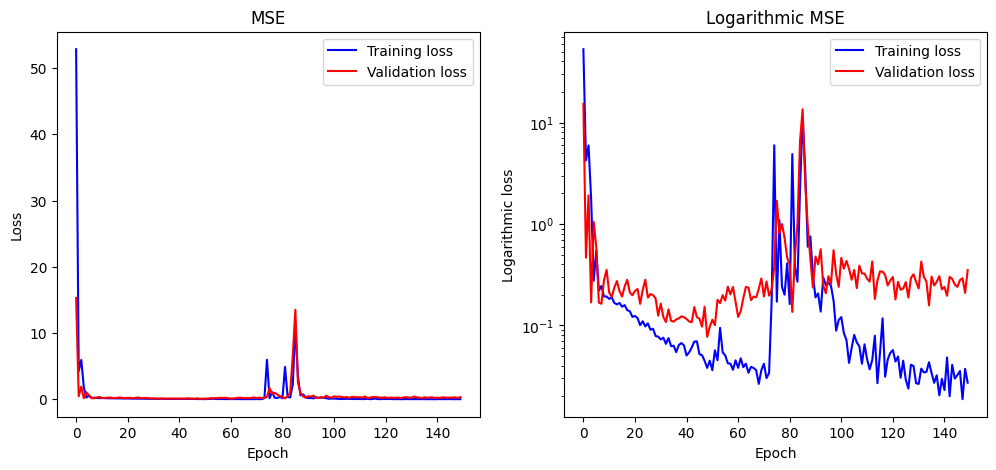

In [106]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12, 5))
fig.add_subplot(1, 2, 1)
plt.plot(np.asarray(hist_train), 'b', label="Training loss")
plt.plot(np.asarray(hist_valid), 'r', label="Validation loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title("MSE")
plt.legend()

fig.add_subplot(1, 2, 2)
plt.semilogy(np.asarray(hist_train), 'b', label="Training loss")
plt.semilogy(np.asarray(hist_valid), 'r', label="Validation loss")
plt.xlabel('Epoch')
plt.ylabel('Logarithmic loss')
plt.title("Logarithmic MSE")
plt.legend()

plt.show()

In [107]:
# save the checkpoint model training if necessary
output_path = "./"

torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss.item()
            }, Path(output_path,'lstm_train_checkpoint.pt'))

#### Evaluate model
Now we can evaluate our model with testing set and compare the predictions with the ground truth.

In [108]:
# switch model into evaluation mode
model.eval()
hist_test = []
predictions = []
hist_test_step = 0
for batch_idx, (X_batch, y_batch) in enumerate(test_loader):
    var_X_batch = Variable(X_batch).to(device)
    var_y_batch = Variable(y_batch).to(device)
    optimizer.zero_grad()
    with torch.no_grad():
        output = model(var_X_batch)
        loss = criterion(output[:,-1,:].squeeze(), var_y_batch)
    wandb.log({'testing_loss': loss.item()})
    predictions.append(output.squeeze().cpu().detach().numpy()[:,-1])
    hist_test_step += loss.item()

hist_test.append(hist_test_step / len(test_loader.dataset))
# call wandb finish to stop logging
wandb.finish()

testing_loss,█▁
train_loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
validation_loss,▃▂▂▁▂▂▂▂▁▁▁▁▁▁▂▂▂▂▂▂█▃█▃▂▂▃▃▂▃▂▂▁▂▂▂▃▂▂▃
testing_loss,1.43589
train_loss,0.05494
validation_loss,2.15114


Plot the predictions versus observations and climatology.

In [109]:
# get climatology of target period
left = target_series_sel.sel(i_interval=1).left_bound[0]
right = target_series_sel.sel(i_interval=1).right_bound[0]
days_ofyear = pd.date_range(pd.to_datetime(left.values), pd.to_datetime(right.values), freq="D").day_of_year

preprocessor = preprocess.Preprocessor(
    rolling_window_size=25,
    detrend=None,
    subtract_climatology=True,
)
preprocessor.fit(target_field["t2m"].sel(cluster=3)) # only fitting, not transforming
target_clim = preprocessor._climatology.sel(dayofyear=days_ofyear).mean().values

The MSE of LSTM forecasts is 2.108
The MSE of climatology is 1.033


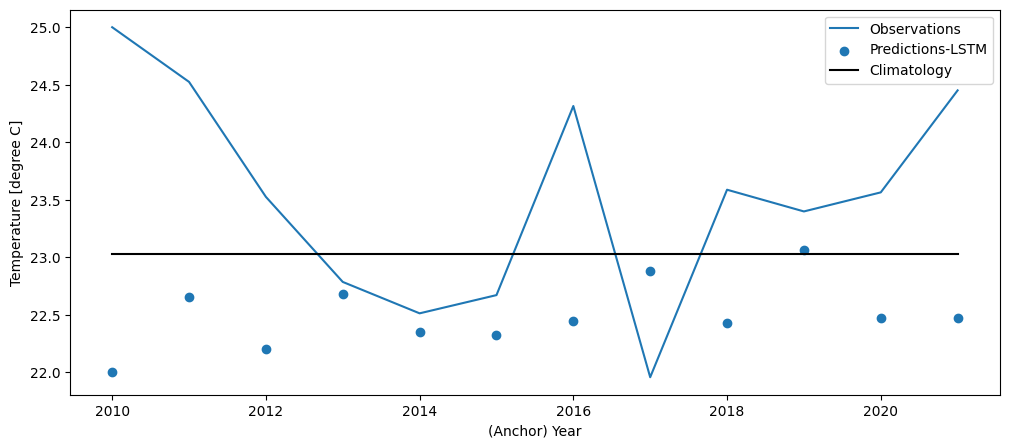

In [110]:
print(
    f"The MSE of LSTM forecasts is {mean_squared_error(ground_truth, np.concatenate(predictions)):.3f}"
)
print(
    f"The MSE of climatology is {mean_squared_error(ground_truth, np.repeat(target_clim, ground_truth.anchor_year.size)):.3f}"
)

ground_truth = target_series_sel[:,-1][-test_samples:]

fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(ground_truth.anchor_year, ground_truth.values.ravel(), label="Observations")
plt.scatter(ground_truth.anchor_year, np.concatenate(predictions), label="Predictions-LSTM")
ax.plot(ground_truth.anchor_year, np.repeat(target_clim, ground_truth.anchor_year.size), 
           label="Climatology", c="black")
plt.xlabel("(Anchor) Year")
plt.ylabel("Temperature [degree C]")
plt.legend()
plt.show()